# Benchmark Quickstart

This notebook mirrors the CLI quickstart flow in an executable format. Use it to 
validate your environment and to inspect the outputs of a short benchmark run.

## 1. Running the CLI from this notebook

Because this notebook lives inside the repo, we can invoke the CLI scripts directly. The helper below ensures the kernel's working directory is the repository root so imports and scripts resolve correctly.

In [1]:
import os
import pathlib
import sys
import yaml

def find_repo_root(start: pathlib.Path) -> pathlib.Path:
    for path in (start, *start.parents):
        if (path / 'codes').is_dir() and (path / 'docs').is_dir():
            return path
    raise RuntimeError('Could not locate repo root; start the kernel from within the project directory.')

repo_root = find_repo_root(pathlib.Path.cwd().resolve())
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print(f"Working directory set to {repo_root}")

config_path = repo_root / "configs" / "train_eval" / "config_minimal.yaml"
print(f"Using config file at {config_path}")
config = yaml.safe_load(config_path.read_text())
print("Configuration:")
print(yaml.dump(config, sort_keys=False))
training_id = config["training_id"]


Working directory set to /export/home/rjanssen/CODES-Benchmark
Using config file at /export/home/rjanssen/CODES-Benchmark/configs/train_eval/config_minimal.yaml
Configuration:
training_id: example_config_minimal
surrogates:
- FullyConnected
- LatentPoly
batch_size:
- 65536
- 512
epochs:
- 20
- 20
dataset:
  name: lotka_volterra
  tolerance: 1e-15
devices:
- cpu



## 2. Trigger training

Uncomment the next cell when you want to actually run training from inside the 
notebook. Keeping it as a string prevents accidental long-running jobs when the 
notebook is rendered on the documentation site.

In [2]:
!"{sys.executable}" run_training.py --config {config_path}

8 0

--------------------------------------------------------------------------------
|                              Starting training                               |
--------------------------------------------------------------------------------

Training models sequentially on device cpu
Overall Progress                        :   0%|  |   0/2 models trained [elapsed
FullyConnected main             (cpu)   :   0%|     |     0/20 [00:00<?, ?it/s ]
FullyConnected main             (cpu)   :   0%| |     0/20 [00:03<?, ?it/s , tra
FullyConnected main             (cpu)   :   5%| |     1/20 [00:03<01:00,  3.21s/
FullyConnected main             (cpu)   :  10%| |     2/20 [00:04<00:39,  2.19s/
FullyConnected main             (cpu)   :  15%|▏|     3/20 [00:06<00:31,  1.86s/
FullyConnected main             (cpu)   :  20%|▏|     4/20 [00:07<00:27,  1.71s/
FullyConnected main             (cpu)   :  25%|▎|     5/20 [00:09<00:24,  1.60s/
FullyConnected main             (cpu)   :  30%|▎|     6/20 [

Sorry for the suboptimal formatting of the progress bars - they look much nicer in the terminal, and we even have stacked and organised progress bars for parallel training runs there.

## 3. Benchmark and collect metrics

After training finishes, call `run_eval.py` with the same configuration file.

In [3]:
!"{sys.executable}" run_eval.py --config {config_path}


Checking benchmark configuration...
Configuration check passed successfully.

--------------------------------------------------------------------------------
|                     Running benchmark for FullyConnected                     |
--------------------------------------------------------------------------------

All required models for surrogate FullyConnected are present.
Running accuracy benchmark...

--------------------------------------------------------------------------------
|                       Running benchmark for LatentPoly                       |
--------------------------------------------------------------------------------

All required models for surrogate LatentPoly are present.
Running accuracy benchmark...

--------------------------------------------------------------------------------
|                            Evaluation completed.                             |
--------------------------------------------------------------------------------



## 4. Inspect generated results

Let us investigate the files that were created during training and evaluation!

In [4]:
# Use tree visualization if available
import shutil
tree_cmd = shutil.which("tree")
if tree_cmd:
    !"{tree_cmd}" -L 3 trained/{training_id}
    !"{tree_cmd}" -L 3 results/{training_id}
    !"{tree_cmd}" -L 3 plots/{training_id}
else:
    print("The 'tree' command is not available. Please install it to visualize the directory structure.")

trained/example_config_minimal
├── FullyConnected
│   ├── fullyconnected_main.pth
│   └── fullyconnected_main.yaml
├── LatentPoly
│   ├── latentpoly_main.pth
│   └── latentpoly_main.yaml
├── completed.txt
└── config.yaml

3 directories, 6 files
results/example_config_minimal
├── fullyconnected_metrics.yaml
└── latentpoly_metrics.yaml

1 directory, 2 files
plots/example_config_minimal
├── FullyConnected
│   ├── accuracy_delta_dex_per_quantity.jpg
│   ├── accuracy_delta_dex_time.jpg
│   ├── accuracy_rel_error_per_quantity.jpg
│   └── accuracy_rel_errors_time.jpg
└── LatentPoly
    ├── accuracy_delta_dex_per_quantity.jpg
    ├── accuracy_delta_dex_time.jpg
    ├── accuracy_rel_error_per_quantity.jpg
    └── accuracy_rel_errors_time.jpg

3 directories, 8 files


Trained models are stored under `trained/<training_id>/<surrogate>/`.
As you can see, each surrogate has its own subdirectory containing the model (.pth), as well as a YAML file, which contains all model attributes relevant to restore the model later.

Results from evaluation are stored under `results/<training_id>/<surrogate>/`.
For each surrogate, a YAML summary file is created, which contains various metrics computed during evaluation.

Plots generated during evaluation are stored under `plots/<training_id>/<surrogate>/`.
In this very basic setting, four plots were created for each surrogate we trained. 

Next, let us take a look at the contents of the results yaml files and the generated plots!

In [5]:
results_root = repo_root / "results" / training_id
# List all files in results_root
for item in results_root.iterdir():
    print(f"- {item.name}")
    with (results_root / item.name).open() as f:
        content = f.read()
        print(f"Contents of {item.name}:")
        print(content)

- fullyconnected_metrics.yaml
Contents of fullyconnected_metrics.yaml:
n_params: 0
accuracy:
  root_mean_squared_error_log: 11.999552726745605
  median_absolute_error_log: 8.740435600280762
  mean_absolute_error_log: 11.029707908630371
  percentile_absolute_error_log: 21.89702796936035
  root_mean_squared_error_real: 251635024.0
  median_absolute_error_real: 18.237300872802734
  mean_absolute_error_real: 115018664.0
  percentile_absolute_error_real: 617406528.0
  median_relative_error: 1.0
  mean_relative_error: 2023090816.0
  percentile_relative_error: 11246115840.0
  error_percentile: 99
  main_model_training_time: 35.57754993438721
  main_model_epochs: 20

- latentpoly_metrics.yaml
Contents of latentpoly_metrics.yaml:
n_params: 0
accuracy:
  root_mean_squared_error_log: 2.213813543319702
  median_absolute_error_log: 1.4329252243041992
  mean_absolute_error_log: 1.7928467988967896
  percentile_absolute_error_log: 6.6917595863342285
  root_mean_squared_error_real: 185.49114990234375
 

These metrics may be a bit hard to read in raw YAML format. But luckily, we can look at the generated plots as well!

Displaying plots from /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal:
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/FullyConnected/accuracy_delta_dex_per_quantity.jpg for surrogate FullyConnected
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/FullyConnected/accuracy_rel_error_per_quantity.jpg for surrogate FullyConnected
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/FullyConnected/accuracy_delta_dex_time.jpg for surrogate FullyConnected
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/FullyConnected/accuracy_rel_errors_time.jpg for surrogate FullyConnected
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/LatentPoly/accuracy_delta_dex_per_quantity.jpg for surrogate LatentPoly
Loading plot /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal/LatentPoly/accuracy_rel_error_per_quantity.jpg for su

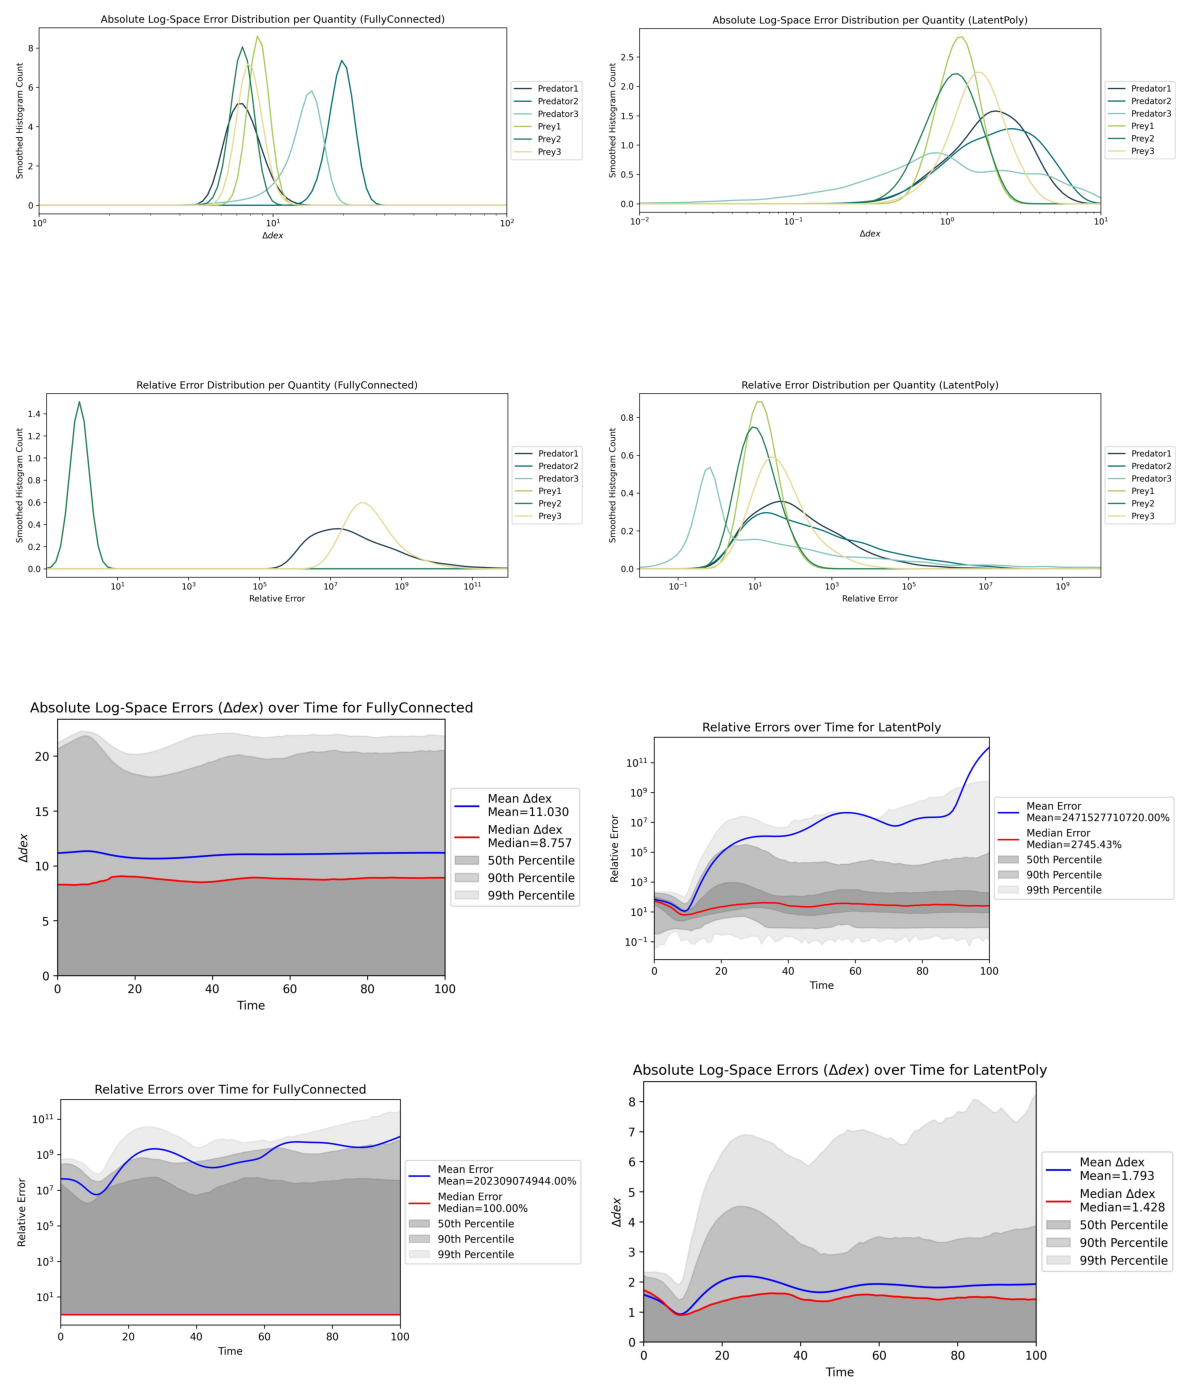

In [6]:
import matplotlib.pyplot as plt

# Create figure with 4x2 subplots
plots_dir = repo_root / "plots" / training_id
print(f"Displaying plots from {plots_dir}:")
fig, axs = plt.subplots(4, 2, figsize=(12, 15))
row = 0
col = 0
for item in plots_dir.iterdir():
    for plot_file in item.iterdir():
        print(f"Loading plot {plot_file} for surrogate {item.name}")
        img = plt.imread(plot_file)
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        row += 1
        if row >= 4:
            row = 0
            col += 1
        
plt.tight_layout()
plt.show()

## 5. Additional Evals & Comparing Surrogates

These plots and metrics already provide some insights into the performance of the trained surrogates.
But since CODES is a benchmark, the crucial part is to compare different surrogates against each other.

Additionally, we can run some more evaluations even with the two models we trained above (one per surrogate). To do this, let us rerun `run_eval.py` with modified configuration!

In [7]:
config.update({
    "losses": True,
    "gradients": True,
    "timing": True,
    "compute": True,
    "compare": True,
    "iterative": True,
})
# Replace the saved config file with the updated one
saved_config_path = repo_root / "trained" / training_id / "config.yaml"
yaml.dump(config, open(saved_config_path, 'w'), sort_keys=False)

# Check contents of updated config file
print("Updated Configuration for Additional Evaluations:")
config_new = yaml.safe_load(saved_config_path.read_text())
print(yaml.dump(config_new, sort_keys=False))

Updated Configuration for Additional Evaluations:
training_id: example_config_minimal
surrogates:
- FullyConnected
- LatentPoly
batch_size:
- 65536
- 512
epochs:
- 20
- 20
dataset:
  name: lotka_volterra
  tolerance: 1e-15
devices:
- cpu
losses: true
gradients: true
timing: true
compute: true
compare: true
iterative: true



Note that we modified the config file which was copied over to the `trained/<training_id>/` directory during training!This is simply because I wanted to avoid creating yet another config file in this quickstart notebook.

Now, let us evaluate the trained surrogates with these additional eval toggles enabled:

In [8]:
!"{sys.executable}" run_eval.py --config {saved_config_path}


Checking benchmark configuration...
Configuration check passed successfully.

--------------------------------------------------------------------------------
|                     Running benchmark for FullyConnected                     |
--------------------------------------------------------------------------------

All required models for surrogate FullyConnected are present.
Loss plots...
Running accuracy benchmark...
Running iterative training benchmark...
Running gradients benchmark...
Running timing benchmark...
Running compute benchmark...
Skipping GPU memory profiling for compute evaluation (requested device is not CUDA).

--------------------------------------------------------------------------------
|                       Running benchmark for LatentPoly                       |
--------------------------------------------------------------------------------

All required models for surrogate LatentPoly are present.
Loss plots...
Running accuracy benchmark...
Running ite

Nice! Now we have some more comprehensive output. As you can see, we get a direct comparison in the CLI with some of the most important metrics across all surrogates. Best values are highlighted with an asterisk (*).

Below, we can again inspect the contents of the results directory to see what additional files were created during this extended evaluation.

In [9]:
# Use tree visualization if available
import shutil
tree_cmd = shutil.which("tree")
if tree_cmd:
    !"{tree_cmd}" -L 3 trained/{training_id}
    !"{tree_cmd}" -L 3 results/{training_id}
    !"{tree_cmd}" -L 3 plots/{training_id}
else:
    print("The 'tree' command is not available. Please install it to visualize the directory structure.")

trained/example_config_minimal
├── FullyConnected
│   ├── fullyconnected_main.pth
│   └── fullyconnected_main.yaml
├── LatentPoly
│   ├── latentpoly_main.pth
│   └── latentpoly_main.yaml
├── completed.txt
└── config.yaml

3 directories, 6 files
results/example_config_minimal
├── all_metrics.csv
├── fullyconnected_metrics.yaml
├── latentpoly_metrics.yaml
├── metrics_table.csv
└── metrics_table.txt

1 directory, 5 files
plots/example_config_minimal
├── FullyConnected
│   ├── accuracy_delta_dex_per_quantity.jpg
│   ├── accuracy_delta_dex_time.jpg
│   ├── accuracy_rel_error_per_quantity.jpg
│   ├── accuracy_rel_errors_time.jpg
│   ├── example_preds_iterative.jpg
│   ├── gradient_error_heatmap.jpg
│   └── losses_main.jpg
├── LatentPoly
│   ├── accuracy_delta_dex_per_quantity.jpg
│   ├── accuracy_delta_dex_time.jpg
│   ├── accuracy_rel_error_per_quantity.jpg
│   ├── accuracy_rel_errors_time.jpg
│   ├── example_preds_iterative.jpg
│   ├── gradient_error_heatmap.jpg
│   └── losses_main.jpg
├──

Nothing changed in the trained model directories, but the results directories now contain additional summary files with more metrics computed during this extended evaluation, and explicit comparisons across surrogates, since we enabled the `compare` toggle in the config.

Let us look at some of the additional plots we generated during this extended evaluation. We will start with results for one of the surrogates (`FullyConnected`), and then look at comparison plots across all surrogates.

Displaying new plots from /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal:
Showing plot losses_main.jpg
Showing plot example_preds_iterative.jpg
Showing plot gradient_error_heatmap.jpg


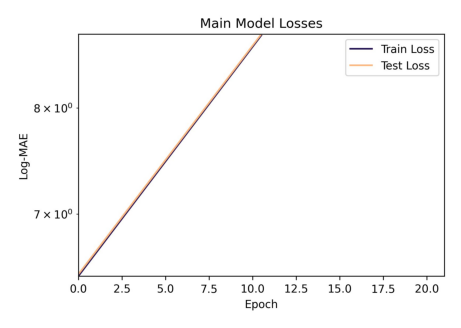

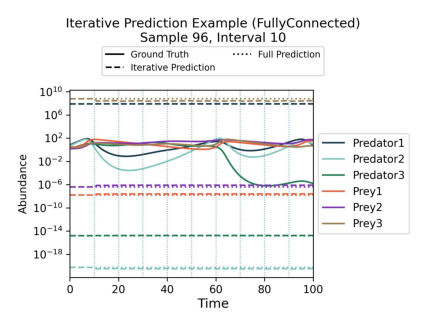

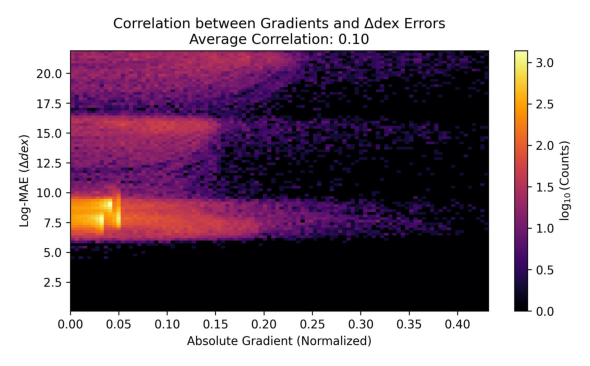

In [10]:
new_plot_identifiers = ["losses_main.jpg", "example_preds_iterative.jpg", "gradient_error_heatmap.jpg"]

print(f"Displaying new plots from {plots_dir}:")
for i, plot_id in enumerate(new_plot_identifiers):
    plot_file = None
    for item in plots_dir.iterdir():
        candidate = item / plot_id
        if candidate.exists():
            plot_file = candidate
            break
    if plot_file is not None:
        print(f"Showing plot {plot_file.name}")
        img = plt.imread(plot_file)
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis('off')
    else:
        print(f"Plot {plot_id} not found in {plots_dir}")
plt.tight_layout()
plt.show()

Of course, the plots look a bit weird because we did not really train for long enough. But you get the idea!

Now, let us look at some comparison plots across the two surrogates we trained.

Displaying comparison plots from /export/home/rjanssen/CODES-Benchmark/plots/example_config_minimal:
Showing comparison plot accuracy_rel_errors_time_models.jpg


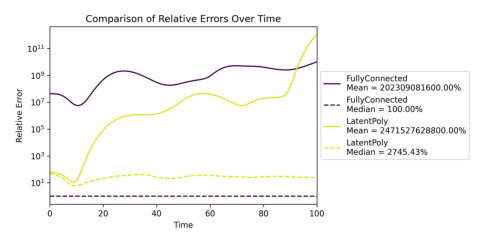

Showing comparison plot accuracy_error_dist_deltadex.jpg


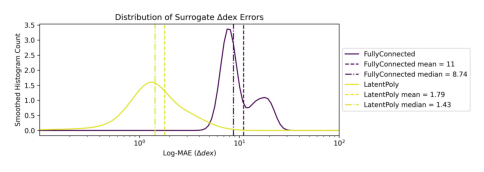

Showing comparison plot losses_main_model.jpg


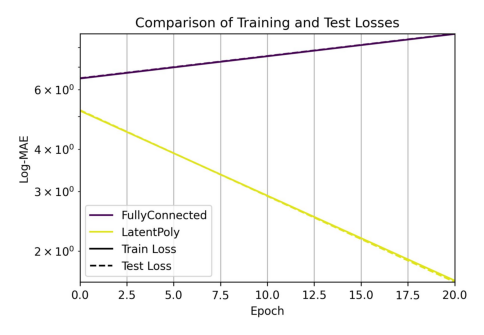

Showing comparison plot iterative_delta_dex_time.jpg


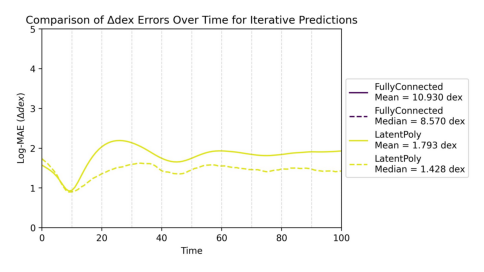

Showing comparison plot timing_inference.jpg


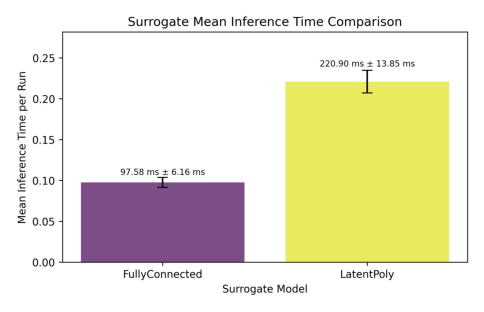

In [11]:
comparison_plot_identifiers = ["accuracy_rel_errors_time_models.jpg", "accuracy_error_dist_deltadex.jpg", "losses_main_model.jpg", "iterative_delta_dex_time.jpg", "timing_inference.jpg"]

print(f"Displaying comparison plots from {plots_dir}:")
# This time, the plots live directly in plots_dir
for i, plot_id in enumerate(comparison_plot_identifiers):
    plot_file = plots_dir / plot_id
    if plot_file.exists():
        print(f"Showing comparison plot {plot_file.name}")
        img = plt.imread(plot_file)
        plt.figure(figsize=(6, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    else:
        print(f"Comparison plot {plot_id} not found in {plots_dir}")

The above plots yield some insights into how the two surrogates compare against each other. Of course, for lack of proper training, the only plot that really shows us something meaningful is the timing plot, where we can see that both surrogates are roughly on par for this simple dataset.*

## End of Benchmark Quickstart - Congratulations!